In [43]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance


In [44]:
dating = pd.read_csv('SpeedDatingData1.csv', skiprows=1)
dating.head()
dating.columns

Index(['iid', 'id', 'gender', 'idg', 'condtn', 'wave', 'round', 'position',
       'positin1', 'order',
       ...
       'attr3_3', 'sinc3_3', 'intel3_3', 'fun3_3', 'amb3_3', 'attr5_3',
       'sinc5_3', 'intel5_3', 'fun5_3', 'amb5_3'],
      dtype='object', length=195)

add more variables for model c

In [ ]:
 
# 1. SELECT COLUMNS
columns_to_keep = [
    'iid', 'id', 'idg', 'wave',
    'match',
    'gender',
    'age',
    'age_o',
    'race',
    'race_o',
    'attr1_1',
    'sinc1_1',
    'intel1_1',
    'fun1_1',
    'amb1_1',
    'shar1_1',
    'pf_o_att',
    'pf_o_sin',
    'pf_o_int',
    'pf_o_fun',
    'pf_o_amb',
    'pf_o_sha', 
    'attr', #add variables for model C
    'sinc', 'intel', 'fun', 'amb', 'shar', 'attr_o', 'sinc_o','intel_o','fun_o','amb_o','shar_o']

dating = dating[columns_to_keep].copy()



# 2. FILTER FOR WAVE 1–5
dating = dating[dating['wave'].between(1, 5)]
print(f"Shape after wave filtering (1-5): {dating.shape}")

 
# 3. EDA COPY (FULL sample: gender 0 + 1)
dating_full = dating.copy()  


# 4. MISSING VALUES REPORT (ONLY REPORT)
print("\nMissing values in each column (EDA view):")
print(dating_full.isna().sum())

 
# 5. MODELING DATASET
# Apply gender = 0 and drop missing vals
dating_model = dating_full[
    dating_full['gender'] == 0
].dropna().copy()

print(f"\nShape of modeling dataset (gender=0, dropna): {dating_model.shape}")

print("\nDataset info for modeling:")
dating_model.info()


Shape after wave filtering (1-5): (1846, 34)

Missing values in each column (EDA view):
iid           0
id            0
idg           0
wave          0
match         0
gender        0
age          30
age_o        39
race         20
race_o       30
attr1_1      36
sinc1_1      36
intel1_1     36
fun1_1       46
amb1_1       56
shar1_1      56
pf_o_att     46
pf_o_sin     46
pf_o_int     46
pf_o_fun     55
pf_o_amb     64
pf_o_sha     64
attr         26
sinc         43
intel        42
fun          68
amb         132
shar        221
attr_o       36
sinc_o       53
intel_o      52
fun_o        78
amb_o       142
shar_o      230
dtype: int64

Shape of modeling dataset (gender=0, dropna): (634, 34)

Dataset info for modeling:
<class 'pandas.core.frame.DataFrame'>
Index: 634 entries, 0 to 1745
Data columns (total 34 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   iid       634 non-null    int64  
 1   id        634 non-null    float64
 2   idg     

dec tree model a : demographics

In [ ]:

# Model A: Demographics


X_A = dating_model[['age', 'age_o', 'race', 'race_o']]
y = dating_model['match']

X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(
    X_A, y, test_size=0.25, random_state=42, stratify=y
)

dt_A = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=20,
    random_state=42
)

dt_A.fit(X_train_A, y_train_A)

y_pred_A = dt_A.predict(X_test_A)
y_prob_A = dt_A.predict_proba(X_test_A)[:, 1]

print("Model A — Decision Tree")
print("Accuracy:", accuracy_score(y_test_A, y_pred_A))
print("ROC AUC:", roc_auc_score(y_test_A, y_prob_A))
print(classification_report(y_test_A, y_pred_A))


Model A — Decision Tree
Accuracy: 0.7987421383647799
ROC AUC: 0.5664370078740157
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       127
           1       0.00      0.00      0.00        32

    accuracy                           0.80       159
   macro avg       0.40      0.50      0.44       159
weighted avg       0.64      0.80      0.71       159



/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


model a visual

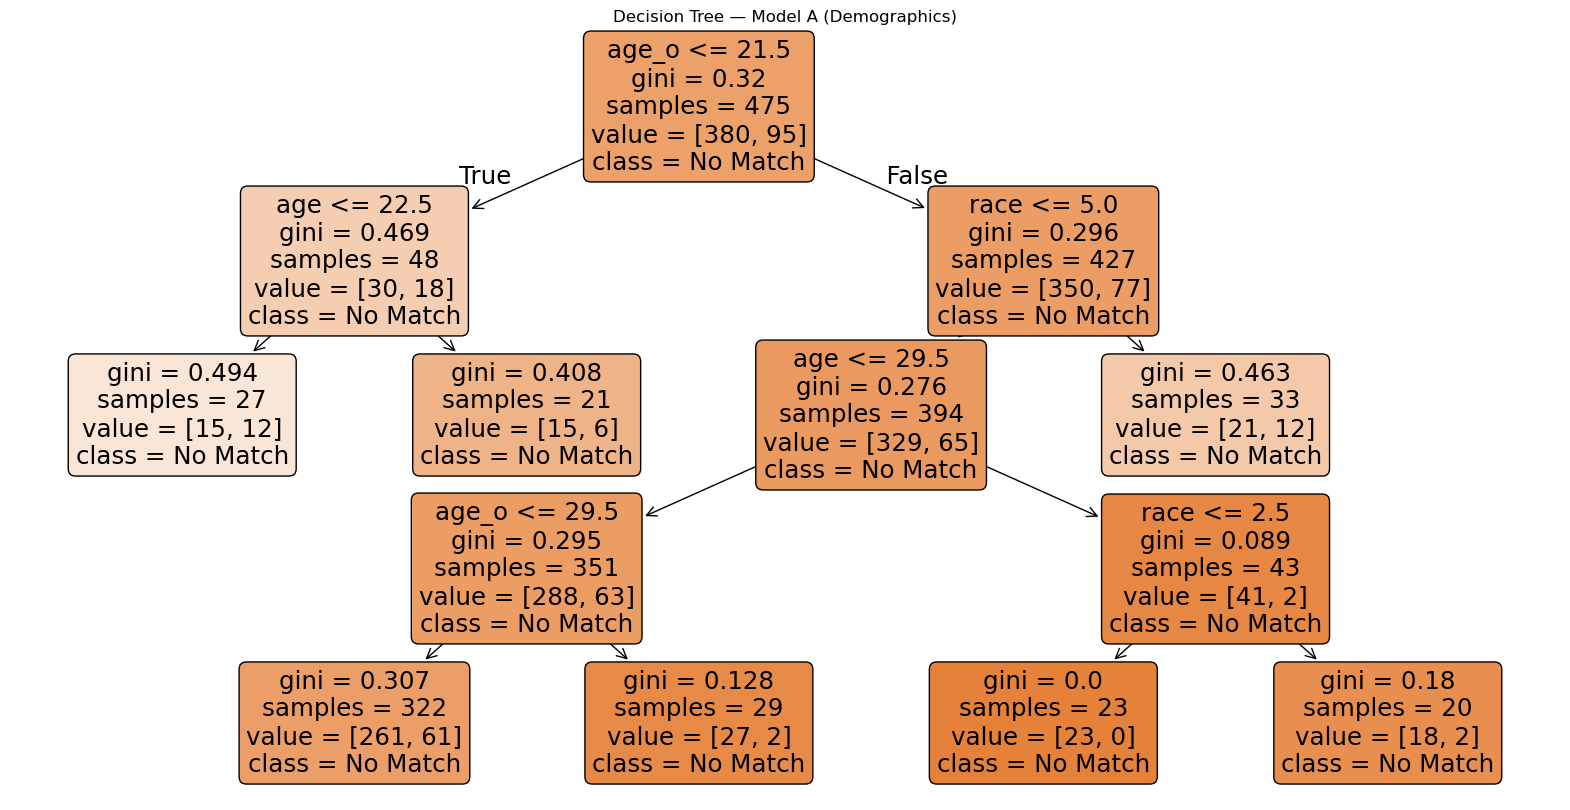

In [47]:
plt.figure(figsize=(20, 10))
plot_tree(
    dt_A,
    feature_names=X_A.columns,
    class_names=['No Match', 'Match'],
    filled=True,
    rounded=True
)
plt.title("Decision Tree — Model A (Demographics)")
plt.show()


mode b : dating theory weights

In [ ]:

# Model B: Dating Theory Weights


X_B = dating_model[
    [
        'attr1_1',
        'sinc1_1',
        'intel1_1',
        'fun1_1',
        'amb1_1',
        'shar1_1',
        'pf_o_att',
        'pf_o_sin',
        'pf_o_int',
        'pf_o_fun',
        'pf_o_amb',
        'pf_o_sha'
    ]
]

y = dating_model['match']

X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(
    X_B, y, test_size=0.25, random_state=42, stratify=y
)

dt_B = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=20,
    random_state=42
)

dt_B.fit(X_train_B, y_train_B)

y_pred_B = dt_B.predict(X_test_B)
y_prob_B = dt_B.predict_proba(X_test_B)[:, 1]

print("Model B — Decision Tree")
print("Accuracy:", accuracy_score(y_test_B, y_pred_B))
print("ROC AUC:", roc_auc_score(y_test_B, y_prob_B))
print(classification_report(y_test_B, y_pred_B))


Model B — Decision Tree
Accuracy: 0.7610062893081762
ROC AUC: 0.5684055118110236
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       127
           1       0.20      0.06      0.10        32

    accuracy                           0.76       159
   macro avg       0.50      0.50      0.48       159
weighted avg       0.68      0.76      0.71       159



model b visual

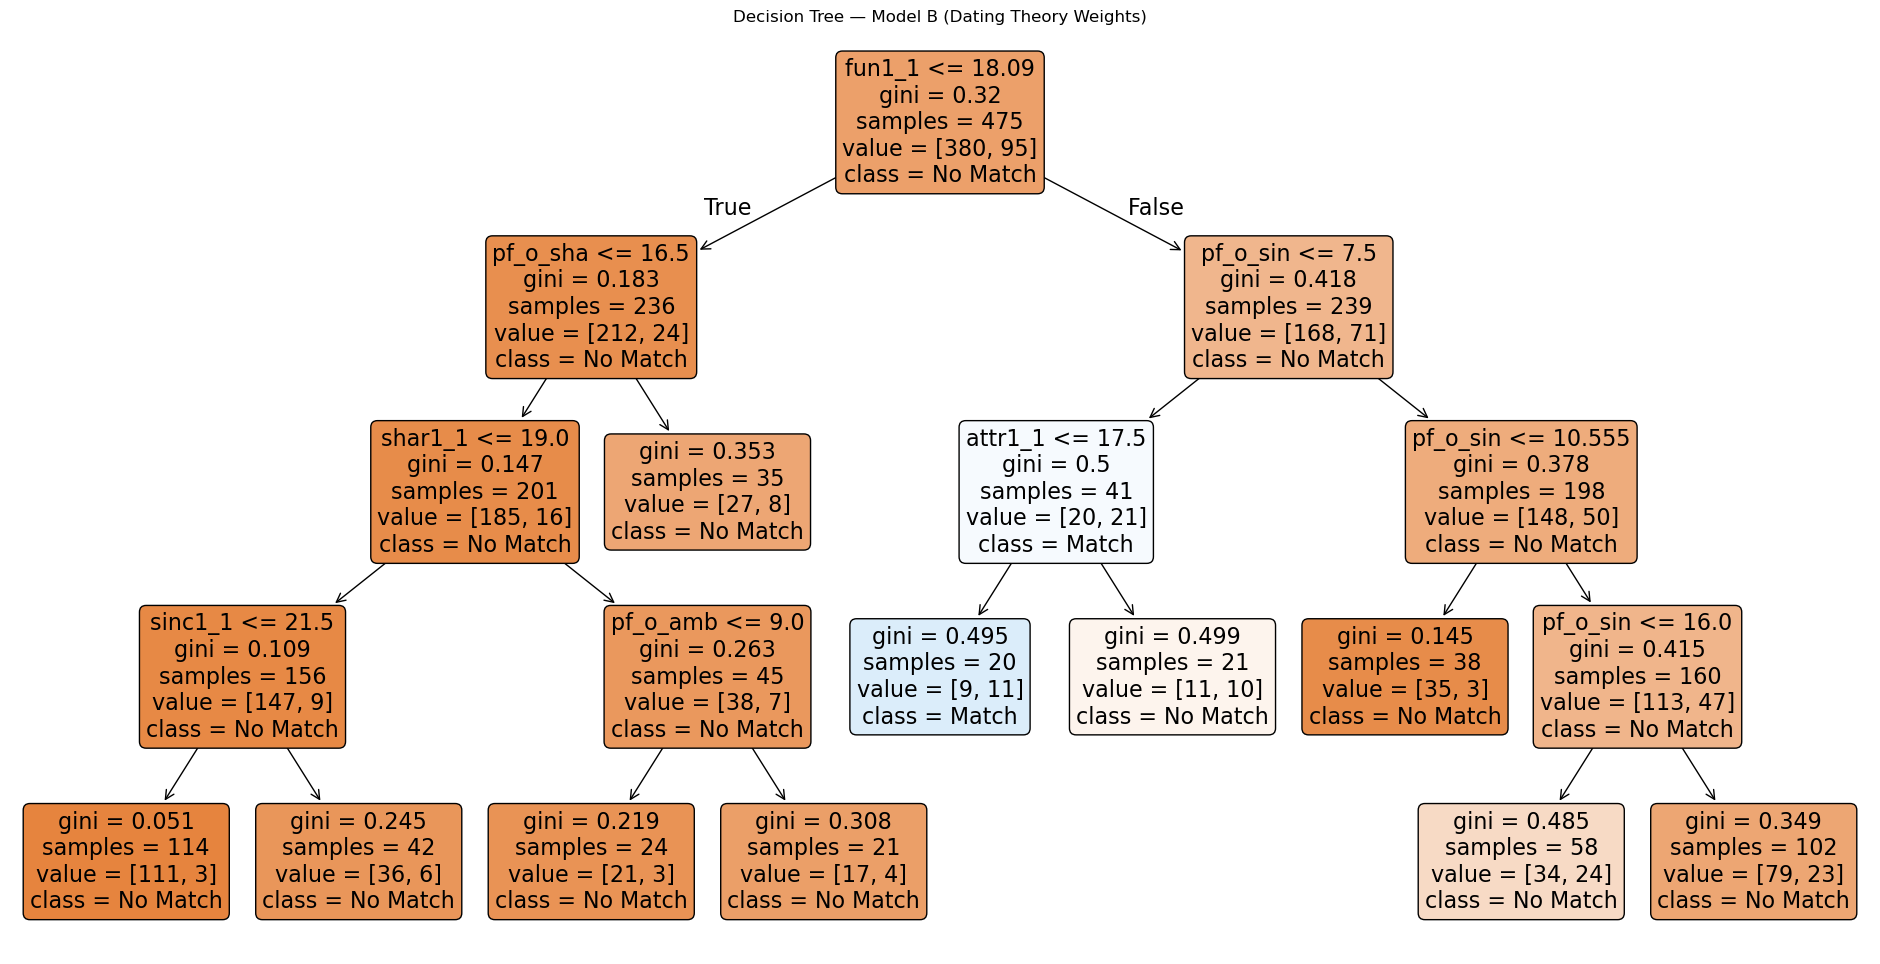

In [49]:
plt.figure(figsize=(24, 12))
plot_tree(
    dt_B,
    feature_names=X_B.columns,
    class_names=['No Match', 'Match'],
    filled=True,
    rounded=True
)
plt.title("Decision Tree — Model B (Dating Theory Weights)")
plt.show()


model c: Model C: Post-Date scorecard Ratings

In [ ]:

# Model C: Post-Date scorecard Ratings


X_C = dating_model[
    [
        'age',
        'age_o',
        'race',
        'race_o',
        'attr',
        'sinc',
        'intel',
        'fun',
        'amb',
        'shar',
        'attr_o',
        'sinc_o',
        'intel_o',
        'fun_o',
        'amb_o',
        'shar_o'
    ]
]

y = dating_model['match']

X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(
    X_C, y, test_size=0.25, random_state=42, stratify=y
)

dt_C = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=20,
    random_state=42
)

dt_C.fit(X_train_C, y_train_C)

y_pred_C = dt_C.predict(X_test_C)
y_prob_C = dt_C.predict_proba(X_test_C)[:, 1]

print("Model C — Decision Tree")
print("Accuracy:", accuracy_score(y_test_C, y_pred_C))
print("ROC AUC:", roc_auc_score(y_test_C, y_prob_C))
print(classification_report(y_test_C, y_pred_C))


Model C — Decision Tree
Accuracy: 0.8176100628930818
ROC AUC: 0.7299458661417323
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       127
           1       0.57      0.41      0.47        32

    accuracy                           0.82       159
   macro avg       0.71      0.66      0.68       159
weighted avg       0.80      0.82      0.81       159



model c visual

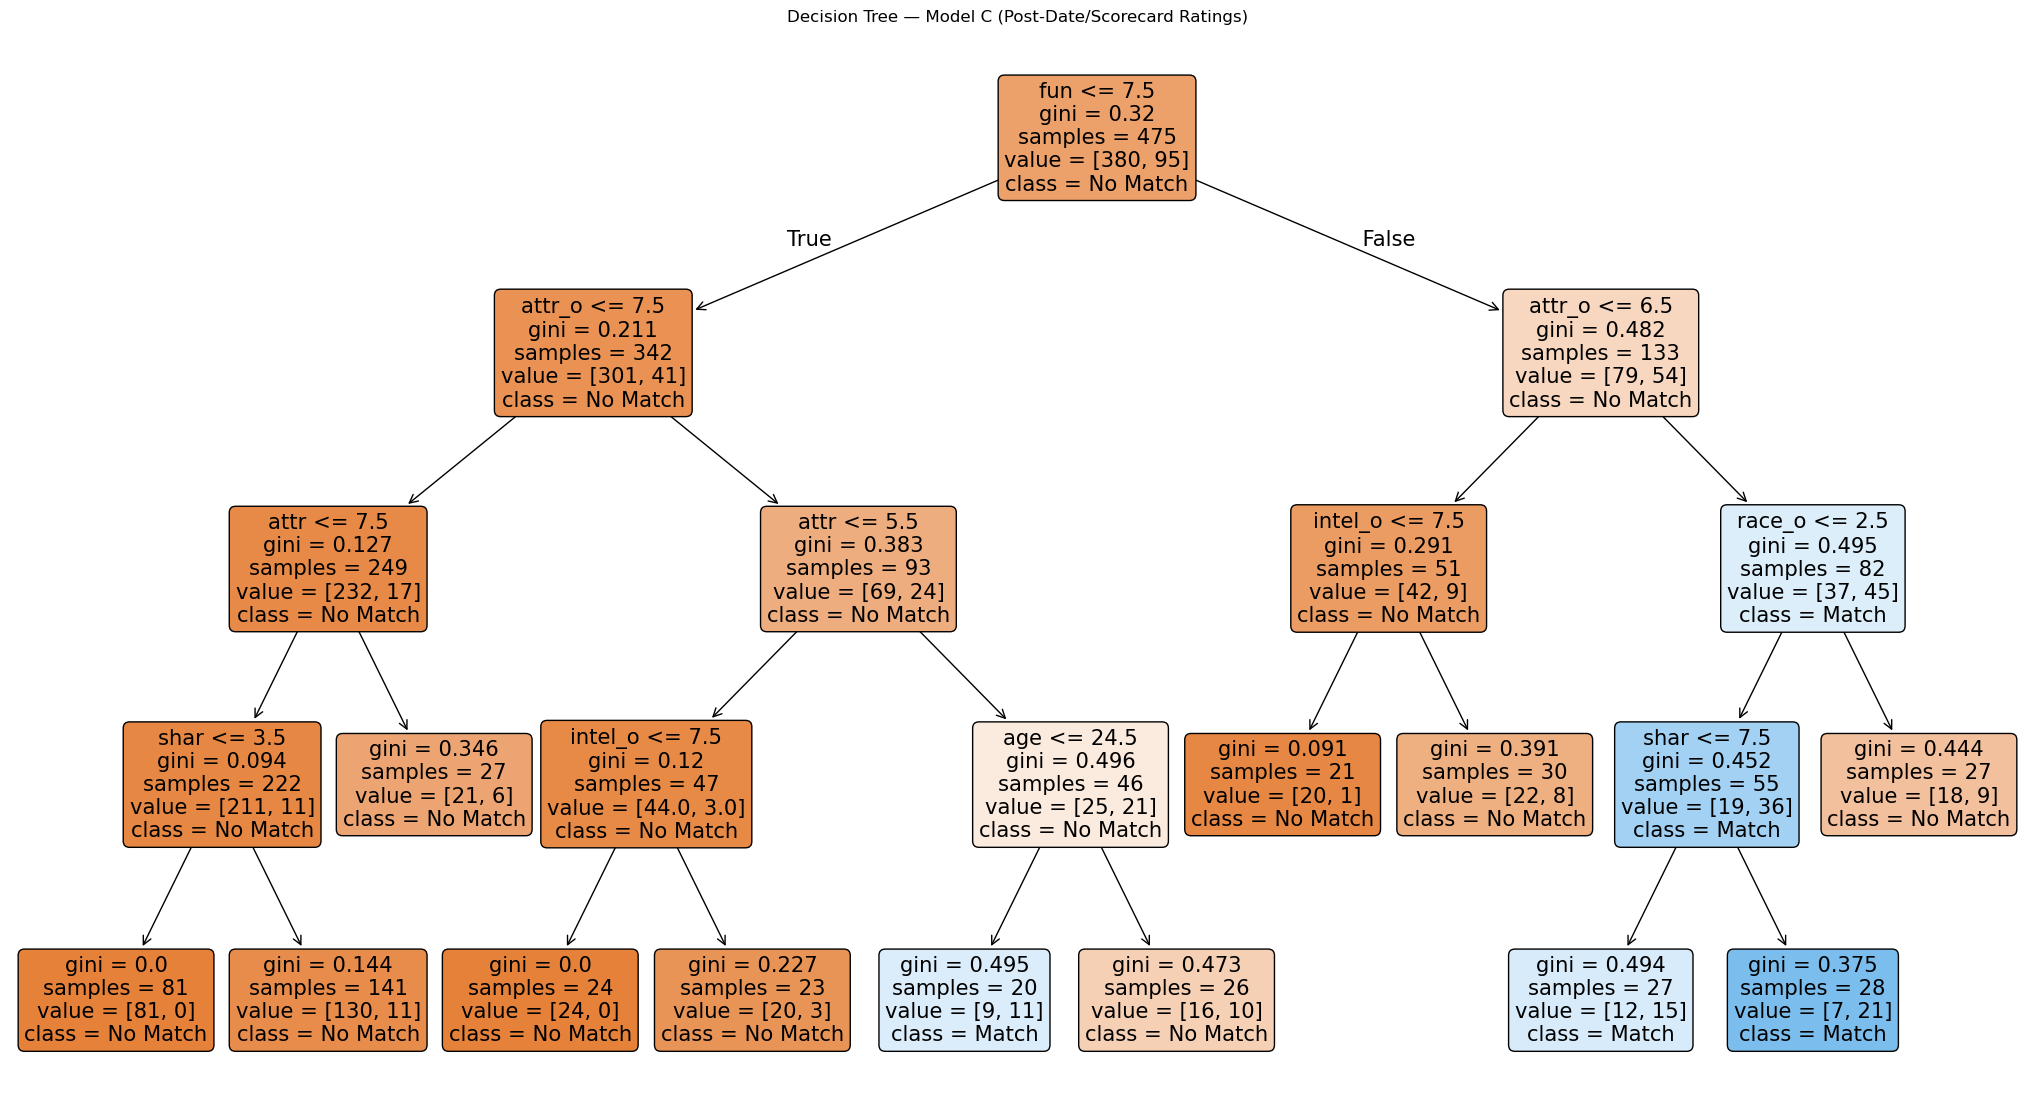

In [52]:
plt.figure(figsize=(26, 14))
plot_tree(
    dt_C,
    feature_names=X_C.columns,
    class_names=['No Match', 'Match'],
    filled=True,
    rounded=True
)
plt.title("Decision Tree — Model C (Post-Date/Scorecard Ratings)")
plt.show()


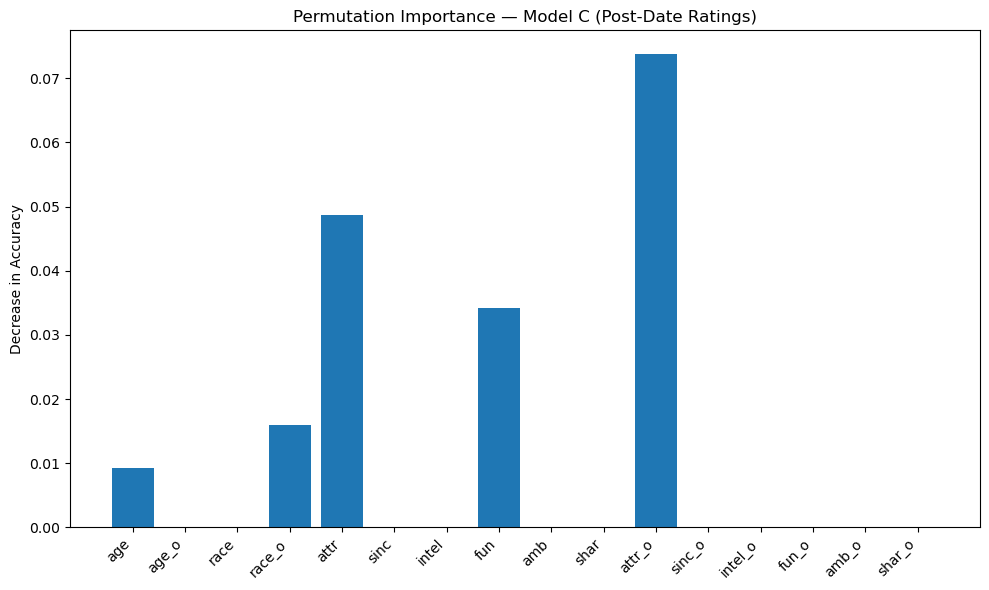

In [53]:
result_C = permutation_importance(
    dt_C,
    X_test_C,
    y_test_C,
    n_repeats=100
)

plt.figure(figsize=(10, 6))
plt.bar(X_test_C.columns, result_C['importances_mean'])
plt.xticks(rotation=45, ha='right')
plt.title('Permutation Importance — Model C (Post-Date Ratings)')
plt.ylabel('Decrease in Accuracy')
plt.tight_layout()
plt.show()
